# Maximum flow problem

***max_flow.ipynb***

Finding the maximum number of vertex-disjoint paths between two nodes in a telecommunications network.

&copy; Copyright 2025-2026 Fair Isaac Corporation

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0.
 
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This example uses FICO&reg; Xpress software. By running it, you agree to the Community License terms of the [Xpress Shrinkwrap License Agreement](https://www.fico.com/en/shrinkwrap-license-agreement-fico-xpress-optimization-suite-on-premises) with respect to the FICO&reg; Xpress software. See the [licensing options](https://www.fico.com/en/fico-xpress-trial-and-licensing-options) overview for additional details and information about obtaining a paid license.

## Problem description and formulation

We wish to test the reliability of a telecommunications network of eleven sites (nodes) connected by bidirectional data links.  The key requirement is that nodes 10 and 11 (the \'source\' and \'sink\') must remain connected even if any three other nodes fail.  By finding the maximum number of vertex‑disjoint paths between nodes 10 and 11, we quantify how many simultaneous failures can be tolerated while preserving connectivity.

Let $\mathcal{A} = \{\exists(i,j), \forall i,j \in \mathcal{N}\}$ be the set of existing undirected arcs in the network, and $f_{i,j}$ a binary decision variable equal to 1 if one unit of flow is sent along arc $i$ to $j$, and 0 otherwise. The source ($s = 10$) and sink ($t = 11$) nodes are defined *a priori*.

We aim to maximize the number of disjoint paths starting from the source. Each arc $(s\to j)$ carrying flow represents a distinct path out of $s$.  By maximizing this sum, we want to pack as many vertex‑disjoint routes as possible:

$$
\max \sum_{(s,j)\in \mathcal{A}} f_{s,j}
$$

* Flow conservation at intermediate nodes:
   $$
   \sum_{(i,k)\in \mathcal{A}} f_{i,k}
   \;=\;
   \sum_{(k,i)\in \mathcal{A}} f_{k,i},
   \quad\forall\,i\in \mathcal{N}\setminus\{s,t\}.
   $$
   - Ensures that for any node $i$ other than $s$ or $t$, the number of incoming flow units equals the number of outgoing units, creating continuous paths.

* Vertex capacity (at most one outgoing):
   $$
   \sum_{(i,k)\in \mathcal{A}} f_{i,k}
   \;\le\; 1,
   \quad\forall\,i\in \mathcal{N}\setminus\{s,t\}.
   $$
   - Limits each intermediate node to at most one unit of outgoing flow, preventing two paths from sharing that node.

* No flow back into the source: 
   $$
   \sum_{(k,s)\in \mathcal{A}} f_{k,s}
   \;=\; 0.
   $$
   - Do not any path from re‑entering the source, preserving a purely outward flow interpretation.

In [ ]:
# Install the necessary packages
%pip install -q xpress matplotlib

## Data preparation

We firstly import the necessary packages and define the node set `NODES = [1…11]` and define `SOURCE=10` and `SINK=11`. We then list all the undirected links in the network in `base_arcs`, and create the directed arc list `ARCS` by adding both $(u,v)$ and $(v,u)$ for each undirected pair. 

In [2]:
import xpress as xp
import matplotlib.pyplot as plt

# Define nodes, source, and sink
NODES = list(range(1, 12))  
SOURCE, SINK = 10, 11

# Undirected base arcs
base_arcs = [
    (1, 2), (1, 3), (1, 11),
    (2, 3), (2, 8), (2, 9),
    (3, 4), (3, 9), (3, 10), (3, 11),
    (4, 5), (4, 6), (4, 11),
    (5, 9), (5, 11),
    (6, 7), (6, 9), (6, 10),
    (7, 8), (7, 10),
    (8, 10),
    (9, 10)
]

# Make arcs bidirectional
ARCS = []
for u, v in base_arcs:
    ARCS.append((u, v))
    ARCS.append((v, u))

## Model implementation

We create an Xpress problem named **Maxflow** and define a set of binary variables `flow` passing the list of arcs to [p.addVariables()](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/python/HTML/problem.addVariables.html). This creates a dictionary whose keys are a tuple of indices.

The **objective** is added via [p.setObjective()](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/python/HTML/problem.setObjective.html) to maximize the total flow leaving the source node. Then, three **constraint** sets are added by passing expressions directly to [p.addConstraint()](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/python/HTML/problem.addConstraint.html) with list comprehension.

After constructing the model, we invoke [p.optimize()](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/python/HTML/problem.optimize.html) to solve it.  We then retrieve the objective value to report the maximum number of disjoint paths, and report each path by tracing through arcs with $f_{i,j}=1$. 

In [ ]:
p = xp.problem(name="Maxflow")

# Binary variables for each directed arc
flow = p.addVariables(ARCS, vartype=xp.binary, name="f")

# Objective function: maximize number of outgoing flow from SOURCE
p.setObjective(
    xp.Sum(flow[(SOURCE, n)] for n in NODES if (SOURCE, n) in flow),
    sense=xp.maximize
)

# Constraints:
# 1. Conservation: sum incoming = sum outgoing
p.addConstraint(
    xp.Sum(flow[(m,n)] for m in NODES if (m,n) in flow)
  == xp.Sum(flow[(n,m)] for m in NODES if (n,m) in flow)
    for n in NODES if n not in (SOURCE, SINK)
)

# 2. Capacity: at most one outgoing unit
p.addConstraint(
    xp.Sum(flow[(n,m)] for m in NODES if (n,m) in flow)
    <= 1
    for n in NODES if n not in (SOURCE, SINK)
)

# 3. No return to SOURCE
p.addConstraint(
    xp.Sum(flow[(m,SOURCE)] for m in NODES if (m, SOURCE) in flow)
    == 0
)

# Solve the problem
p.controls.outputlog = 0        # Turn off solver logging for cleaner output
p.optimize()

# Print total number of disjoint paths
num_paths = int(p.attributes.objval)
print("Total number of paths:", num_paths)

# Print each path
paths = []
sol = p.getSolution(flow)
for n in NODES:
    if (SOURCE, n) in flow and sol[(SOURCE, n)] > 0.5:
        path = [SOURCE, n]
        curr = n
        while curr != SINK:
            for m in NODES:
                if sol.get((curr, m)) is not None and sol.get((curr, m)) > 0.5:
                    path.append(m)
                    curr = m
                    break
        paths.append(path)
        print(" - ".join(map(str, path)))

Total number of paths: 4
10 - 3 - 11
10 - 6 - 4 - 11
10 - 8 - 2 - 1 - 11
10 - 9 - 5 - 11


## Visualization

The visualization consists of three key elements:
* **Base network**: represented by grey lines, each corresponding to an undirected link from the `base_arcs` set.
* **Flow paths**: shown as in differently coloured lines, indicating each directed arc where `flow[idx] = 1`.
* **Nodes**: depicted as white circles placed at each $(x, y)$ coordinate, with the node number displayed above each circle. The node positions are defined by the node coordinates loaded from `POS_LIST` and stored in the dictionary `pos[node]`.

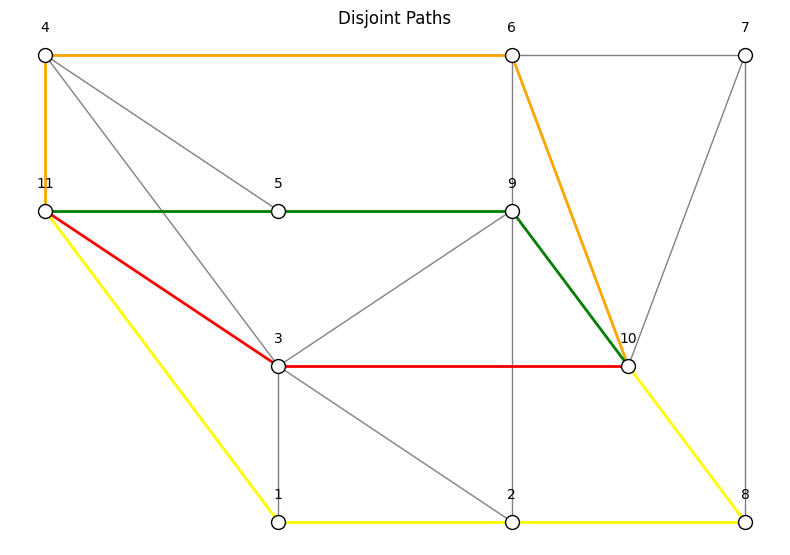

In [4]:
# Visualization: different colors per path
POS_LIST = [
    (40, 10), (70, 10), (40, 30), (10, 70), (40, 50),
    (70, 70), (100, 70), (100, 10), (70, 50), (85, 30), (10, 50)
]
pos = {i+1: POS_LIST[i] for i in range(len(POS_LIST))}

fig, ax = plt.subplots(figsize=(8, 6))
# Draw base network
for u, v in base_arcs:
    x1, y1 = pos[u]
    x2, y2 = pos[v]
    ax.plot([x1, x2], [y1, y2], color='grey', linewidth=1)

# Highlight flow arcs
colors = ['red', 'orange', 'yellow', 'green']  # one color per path
for idx, pth in enumerate(paths):
    color = colors[idx] if idx < len(colors) else 'black'
    for u, v in zip(pth, pth[1:]):
        x1, y1 = pos[u]
        x2, y2 = pos[v]
        ax.plot([x1, x2], [y1, y2], color=color, linewidth=2)

# Draw nodes and labels
for n, (x, y) in pos.items():
    ax.scatter(x, y, s=100, facecolor='white', edgecolor='black', zorder=3)
    ax.text(x, y+3, str(n), ha='center')

ax.set_aspect('equal')
ax.axis('off')
ax.set_title('Disjoint Paths')
plt.tight_layout()
plt.show()
